# Satellite Image Detection Project

## Import Library

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from skimage.feature import local_binary_pattern
import cv2
import numpy as np
import matplotlib.pyplot as plt
import zipfile, os

from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

In [2]:
# Function for displaying images

def sampleImage(folder_path, technique, gray=False):
	base_path = 'satellite-image/' + folder_path
	plt.figure(figsize=(20, 15))

	if gray:
		for i, title in enumerate(os.listdir(base_path), start=1):
			if i == 5: break

			image = cv2.imread(f'{base_path}/{title}', 0)

			plt.subplot(1, 4, i)
			plt.imshow(image, cmap='gray')
			plt.title(f'Image {technique} Sample {i}')
			plt.xticks([])
			plt.yticks([])

	else:
		for i, title in enumerate(os.listdir(base_path), start=1):
			if i == 5: break

			image = cv2.imread(f'{base_path}/{title}')
			image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

			plt.subplot(1, 4, i)
			plt.imshow(image_rgb)
			plt.title(f'Image {technique} Sample {i}')
			plt.xticks([])
			plt.yticks([])

## Download and Extract Images

In [3]:
# !pip install kaggle

In [4]:
!kaggle datasets download -d mahmoudreda55/satellite-image-classification

Dataset URL: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification
License(s): copyright-authors
satellite-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
with zipfile.ZipFile('satellite-image-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('satellite-image')

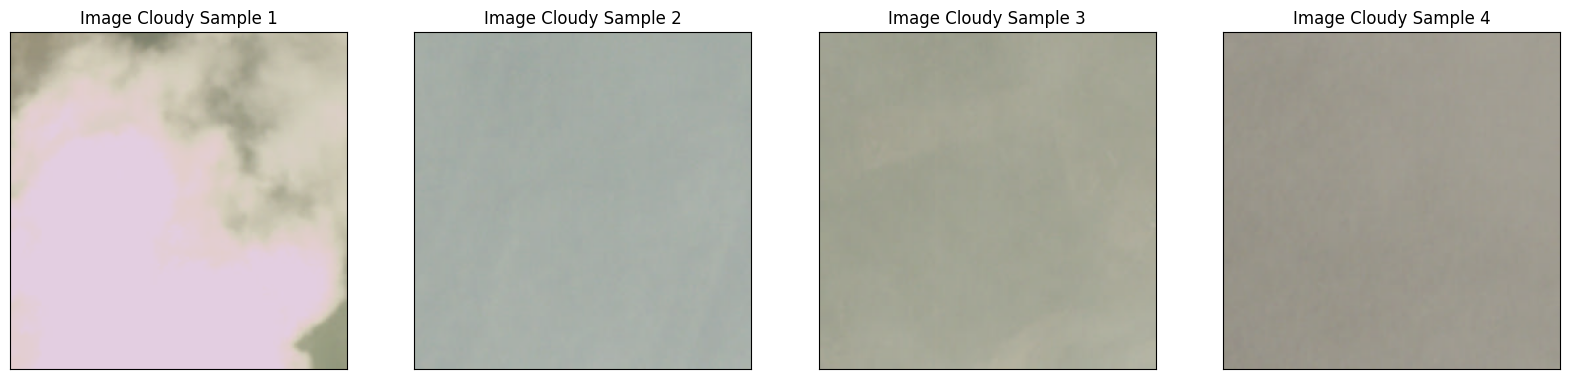

In [6]:
sampleImage('data/cloudy', 'Cloudy')

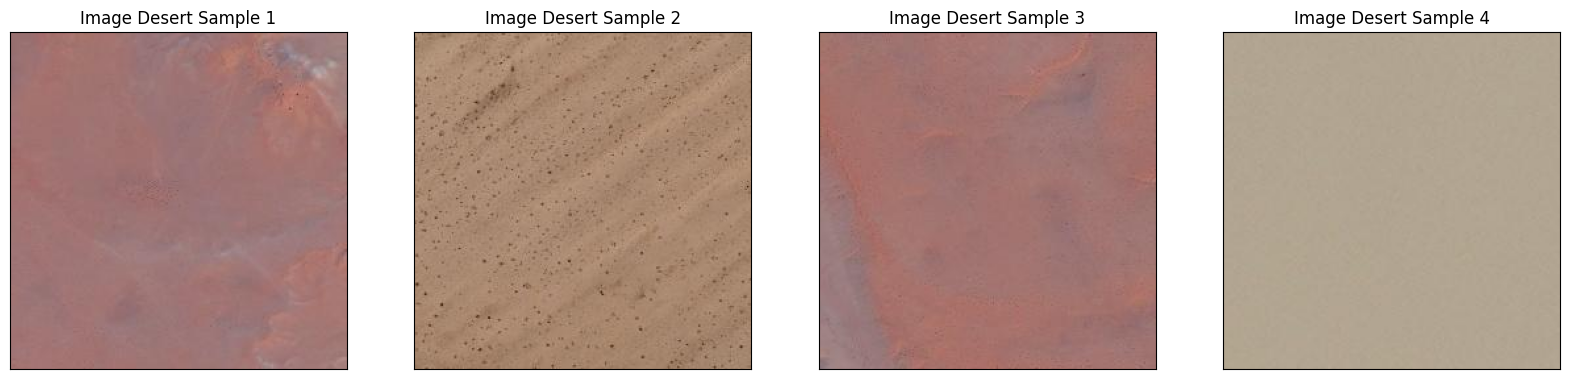

In [7]:
sampleImage('data/desert', 'Desert')

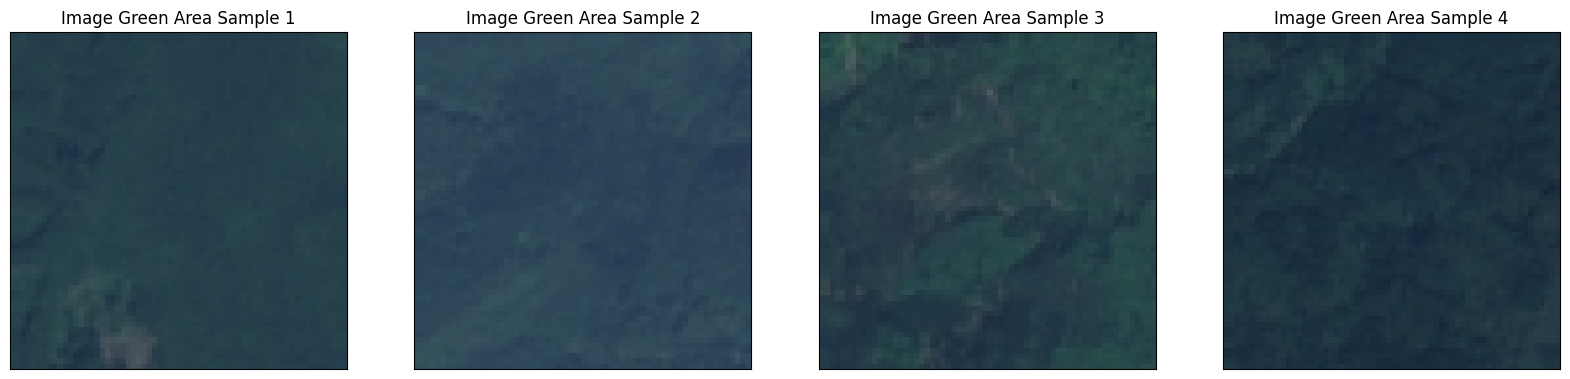

In [8]:
sampleImage('data/green_area', 'Green Area')

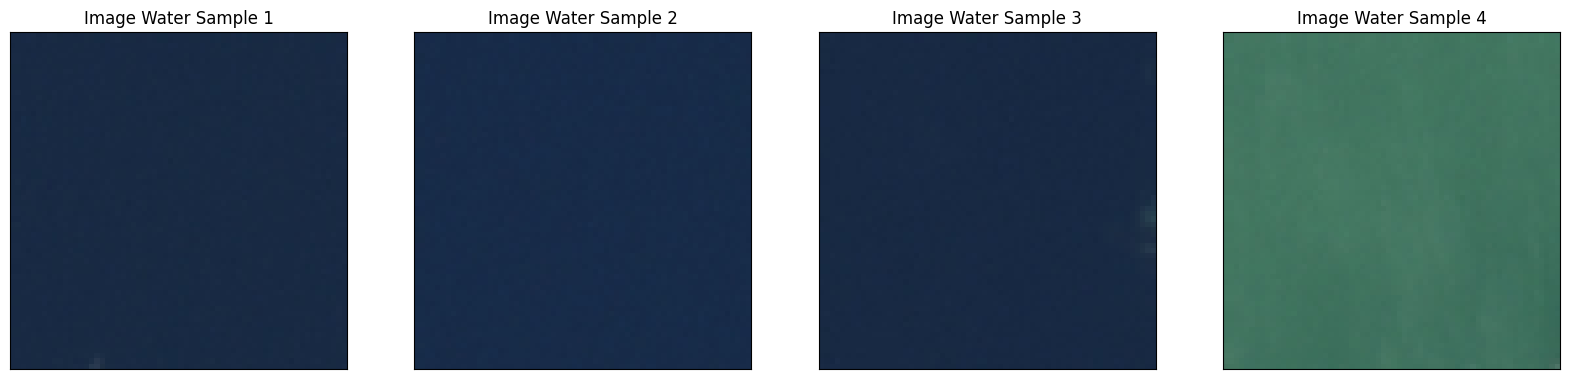

In [9]:
sampleImage('data/water', 'Water')

## Applying Gaussian Blur

In [10]:
def applyGaussianBlur(folder_path):
    base_path = 'satellite-image/data/'
    apply_path = base_path + folder_path
    save_path = f'satellite-image/gaussianBlur/{folder_path}'
    os.makedirs(save_path, exist_ok=True)
    
    for i in os.listdir(apply_path):
        image = cv2.imread(f'{apply_path}/{i}')
        blurred_img = cv2.GaussianBlur(image, (3, 3), 0)
        cv2.imwrite(f'{save_path}/{i}', blurred_img)

In [11]:
for i in os.listdir('satellite-image/data/'):
    applyGaussianBlur(i)

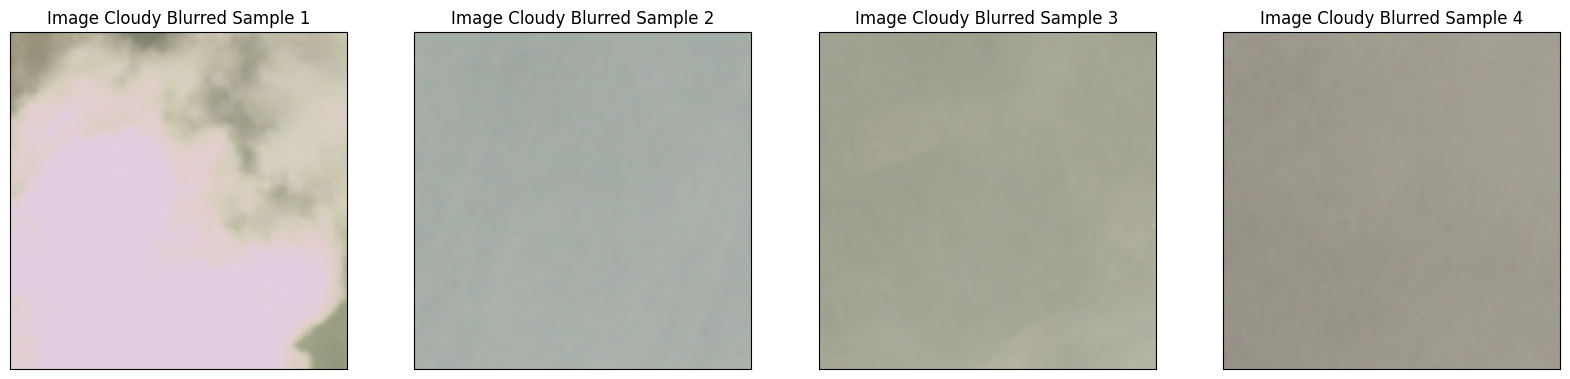

In [12]:
sampleImage('gaussianBlur/cloudy', 'Cloudy Blurred')

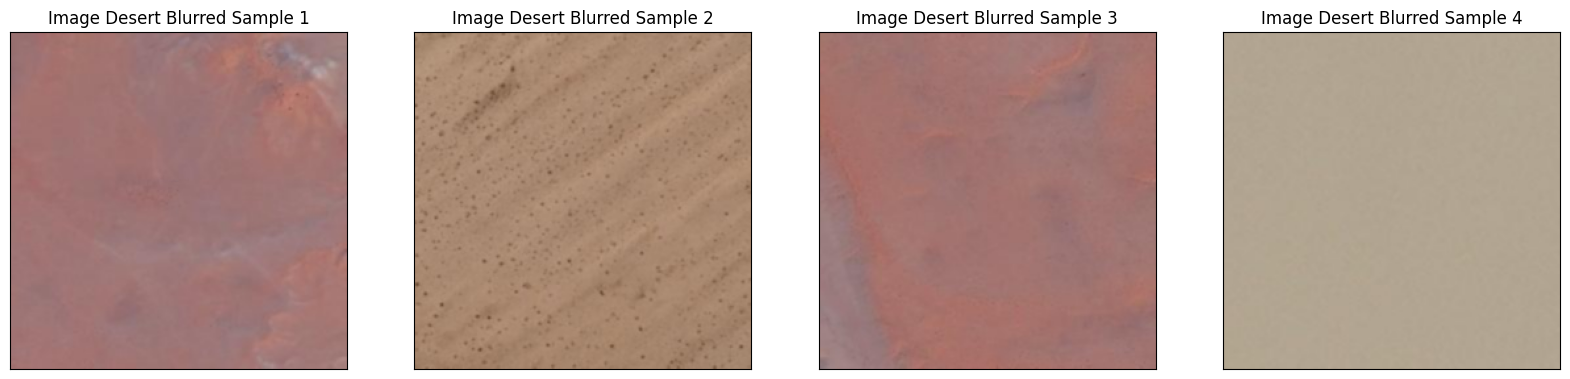

In [13]:
sampleImage('gaussianBlur/desert', 'Desert Blurred')

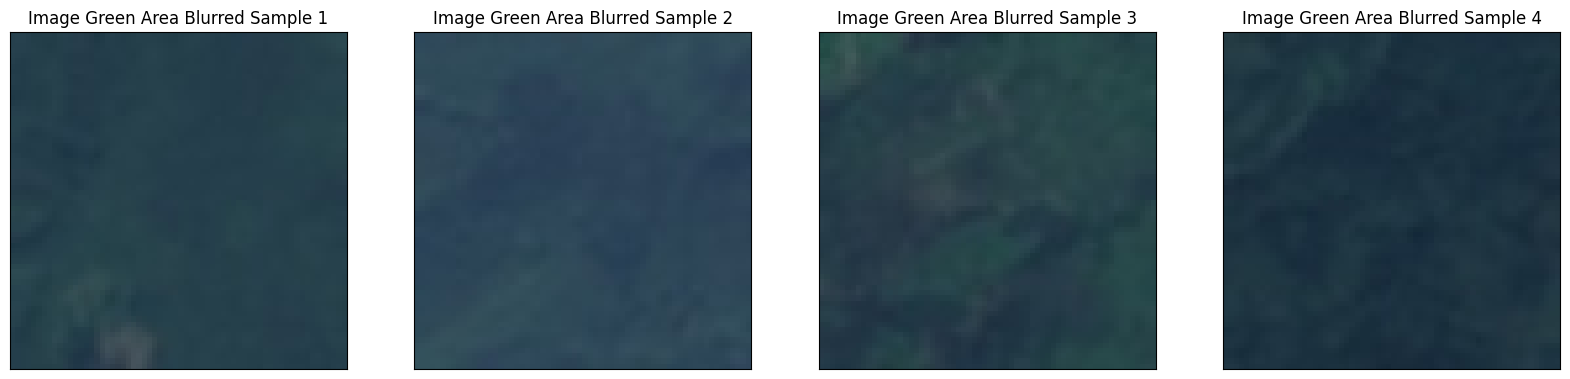

In [14]:
sampleImage('gaussianBlur/green_area', 'Green Area Blurred')

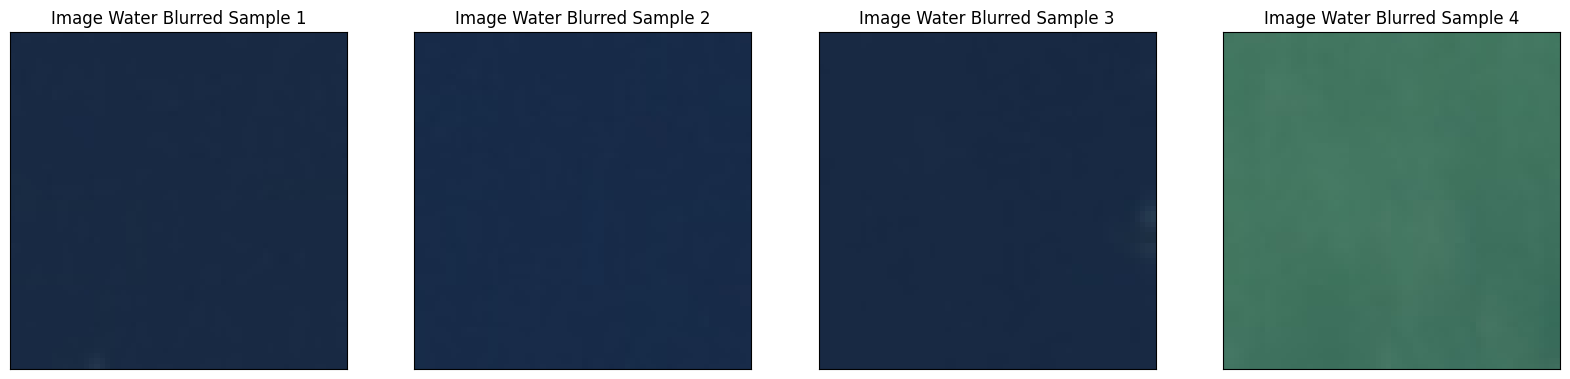

In [15]:
sampleImage('gaussianBlur/water', 'Water Blurred')

## Applying Local Binary Patterns

In [16]:
def applyLBPImage(folder_path):
    base_path = 'satellite-image/gaussianBlur/'
    apply_path = base_path + folder_path
    save_path = f'satellite-image/lbpImage/{folder_path}'
    os.makedirs(save_path, exist_ok=True)
    
    radius = 3
    n_points = 8*radius
    
    for i in os.listdir(apply_path):
        image = cv2.imread(f'{apply_path}/{i}', 0)
        lbp_img = local_binary_pattern(image, n_points, radius, 'uniform')
        lbp_normalized = cv2.normalize(lbp_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        cv2.imwrite(f'{save_path}/{i}', lbp_normalized)

In [17]:
for i in os.listdir('satellite-image/data/'):
    applyLBPImage(i)

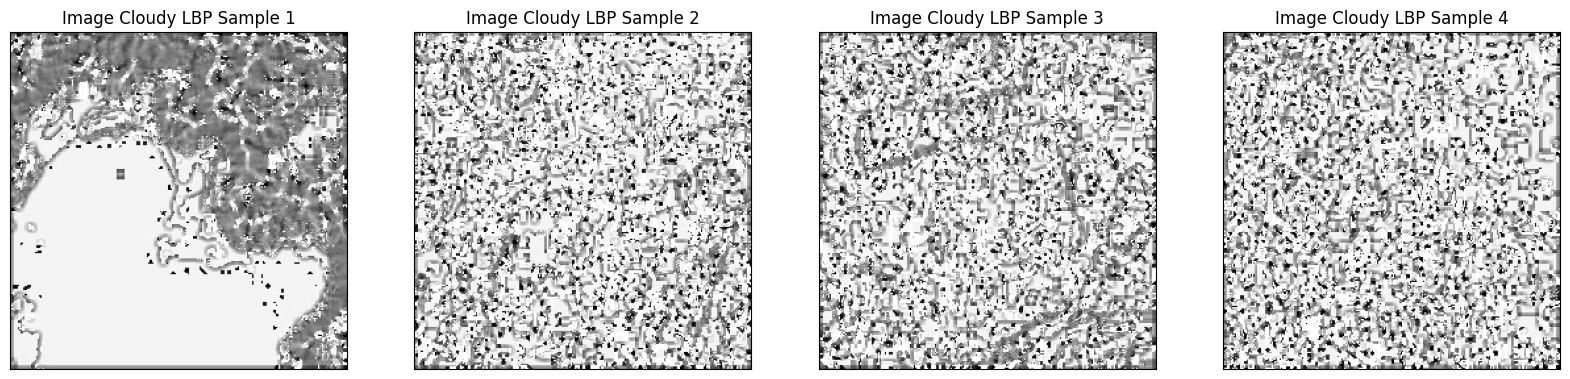

In [18]:
sampleImage('lbpImage/cloudy', 'Cloudy LBP', gray=True)

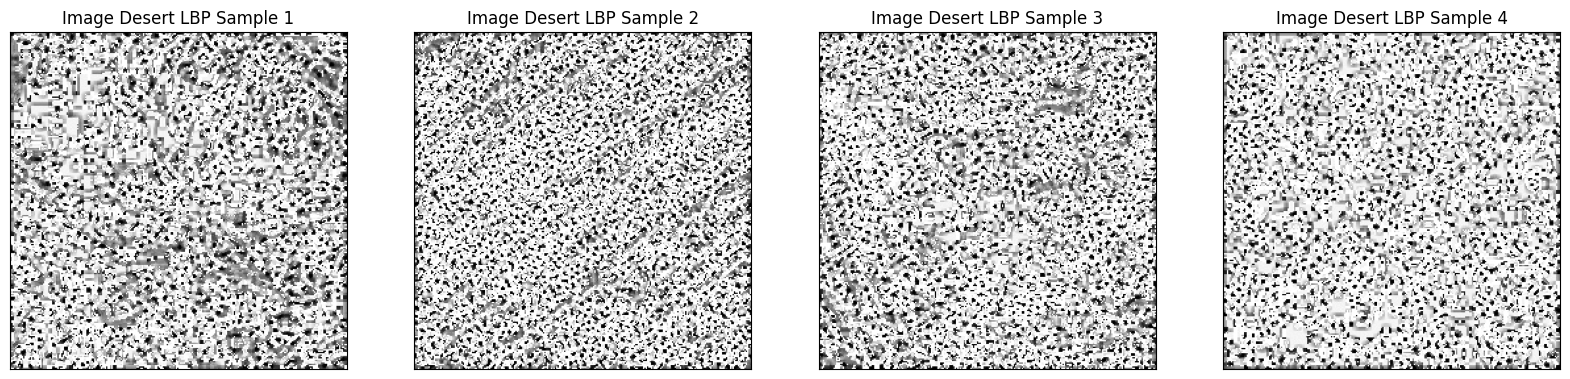

In [19]:
sampleImage('lbpImage/desert', 'Desert LBP', gray=True)

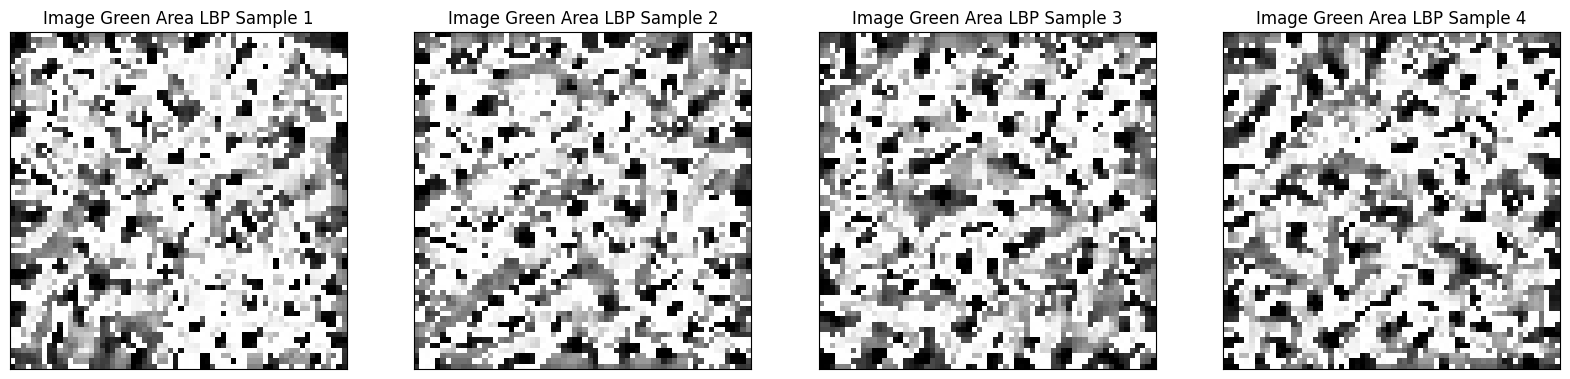

In [20]:
sampleImage('lbpImage/green_area', 'Green Area LBP', gray=True)

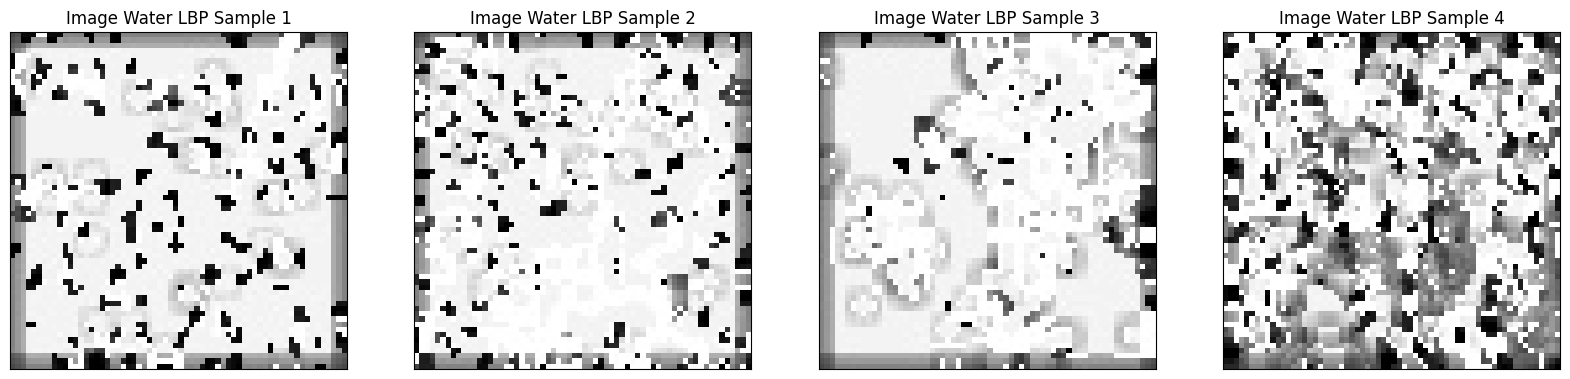

In [21]:
sampleImage('lbpImage/water', 'Water LBP', gray=True)

## Build CNN Model

In [22]:
train_dir = os.path.join(os.getcwd(), 'satellite-image', 'lbpImage')

In [23]:
train_datagen = ImageDataGenerator(
	rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip=True,
    horizontal_flip=True,
    validation_split=0.3
)

In [24]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (100, 100),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

Found 3942 images belonging to 4 classes.
Found 1689 images belonging to 4 classes.


In [25]:
from keras.regularizers import l2

model = Sequential([
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001),kernel_initializer='glorot_uniform', input_shape=(100, 100, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.15),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001), kernel_initializer='glorot_uniform'),
    MaxPooling2D(2, 2),
    Dropout(0.15),
    Flatten(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(4, activation='softmax')
])

In [26]:
model.compile(loss='categorical_crossentropy',
            optimizer=tf.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy', 'precision','recall', 'f1_score'])

In [27]:
class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('precision')>0.9 and 
			logs.get('recall')>0.9 and 
			# logs.get('f1_score')>0.9 and 
			logs.get('val_precision')>0.9 and 
			logs.get('val_recall')>0.9 and 
			# logs.get('val_f1_score')>0.9 and 
			logs.get('loss')<0.3 and 
			logs.get('val_loss')<0.3):
			print("\nAccuracy train dan validate > 90%!")
			self.model.stop_training = True

callbacks = myCallback()

In [28]:
# from keras.callbacks import ReduceLROnPlateau
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=50,
    shuffle=True,
    validation_data=validation_generator,
    validation_steps=3,
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/50
25/25 - 13s - 537ms/step - accuracy: 0.7287 - f1_score: 0.7136 - loss: 0.8405 - precision: 0.8591 - recall: 0.5672 - val_accuracy: 0.2604 - val_f1_score: 0.1033 - val_loss: 2.9627 - val_precision: 0.2604 - val_recall: 0.2604
Epoch 2/50
25/25 - 8s - 339ms/step - accuracy: 0.8700 - f1_score: 0.8633 - loss: 0.5137 - precision: 0.8987 - recall: 0.7987 - val_accuracy: 0.3229 - val_f1_score: 0.1220 - val_loss: 1.9782 - val_precision: 0.3229 - val_recall: 0.3229
Epoch 3/50
25/25 - 8s - 326ms/step - accuracy: 0.8750 - f1_score: 0.8708 - loss: 0.4719 - precision: 0.9019 - recall: 0.8275 - val_accuracy: 0.2708 - val_f1_score: 0.1417 - val_loss: 2.6909 - val_precision: 0.2737 - val_recall: 0.2708
Epoch 4/50
25/25 - 7s - 294ms/step - accuracy: 0.9112 - f1_score: 0.9088 - loss: 0.4046 - precision: 0.9263 - recall: 0.8800 - val_accuracy: 0.2812 - val_f1_score: 0.1505 - val_loss: 2.3267 - val_precision: 0.2812 - val_recall: 0.2812
Epoch 5/50
25/25 - 7s - 261ms/step - accuracy: 0.9375 - f1_

## Evaluate

(0.0, 0.9897291496396065)

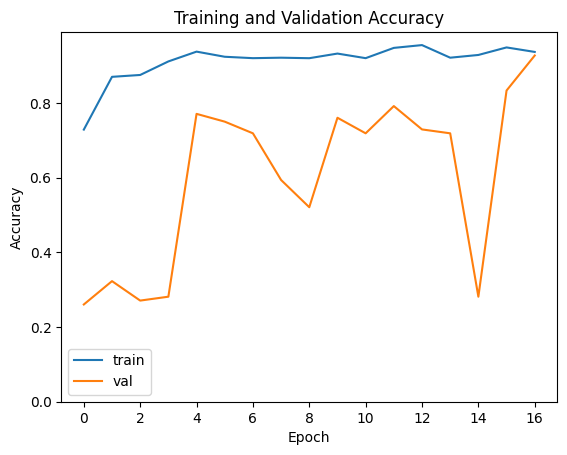

In [29]:
plt.plot(model.history.history['accuracy'], label='Train Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.ylim(ymin=0)

(0.0, 0.9908108040690422)

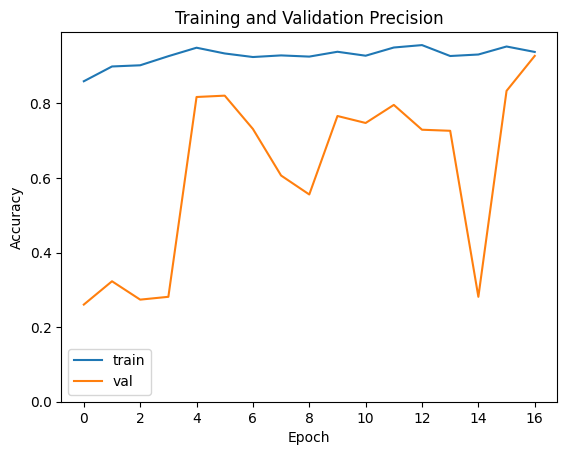

In [30]:
plt.plot(model.history.history['precision'], label='Train Precision')
plt.plot(model.history.history['val_precision'], label='Validation Precision')

plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.ylim(ymin=0)

(0.0, 0.9857916846871376)

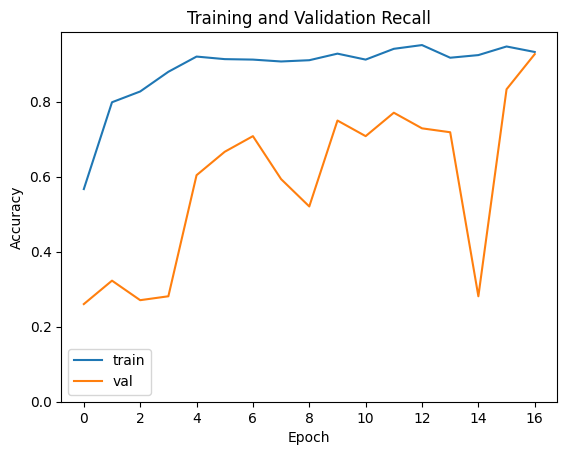

In [31]:
plt.plot(model.history.history['recall'], label='Train Recall')
plt.plot(model.history.history['val_recall'], label='Validation Recall')

plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.ylim(ymin=0)

(0.0, 3.187604521214962)

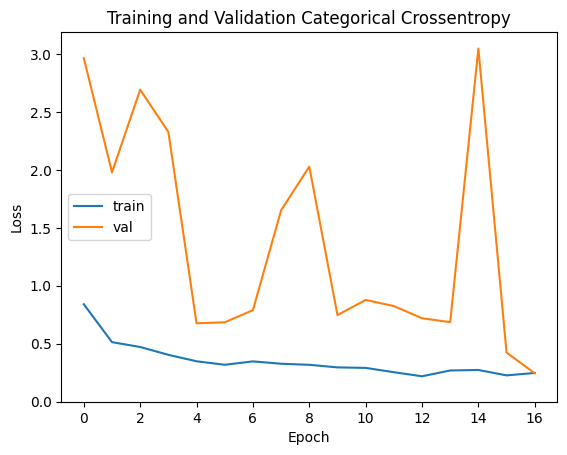

In [32]:
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Categorical Crossentropy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.ylim(ymin=0)

['Forest_1404.jpg', 'Forest_1419.jpg', 'Forest_1456.jpg', 'Forest_1464.jpg', 'Forest_1465.jpg', 'Forest_1470.jpg', 'Forest_1479.jpg', 'Forest_1480.jpg', 'Forest_1488.jpg', 'Forest_1547.jpg', 'Forest_1549.jpg', 'Forest_1585.jpg', 'Forest_1586.jpg', 'Forest_1587.jpg', 'Forest_1591.jpg', 'Forest_1627.jpg', 'Forest_163.jpg', 'Forest_1637.jpg', 'Forest_1638.jpg', 'Forest_164.jpg', 'Forest_1641.jpg', 'Forest_165.jpg', 'Forest_1672.jpg', 'Forest_1675.jpg', 'Forest_1691.jpg', 'Forest_1695.jpg', 'Forest_1731.jpg', 'Forest_1735.jpg', 'Forest_1763.jpg', 'Forest_1768.jpg', 'Forest_1777.jpg', 'Forest_1782.jpg', 'Forest_1802.jpg', 'Forest_1814.jpg', 'Forest_1830.jpg', 'Forest_1861.jpg', 'Forest_188.jpg', 'Forest_1892.jpg', 'Forest_1911.jpg', 'Forest_1934.jpg', 'Forest_1935.jpg', 'Forest_1936.jpg', 'Forest_1937.jpg', 'Forest_1938.jpg', 'Forest_1939.jpg', 'Forest_194.jpg', 'Forest_1940.jpg', 'Forest_1941.jpg', 'Forest_1942.jpg', 'Forest_1943.jpg', 'Forest_1944.jpg', 'Forest_1945.jpg', 'Forest_1946.jpg

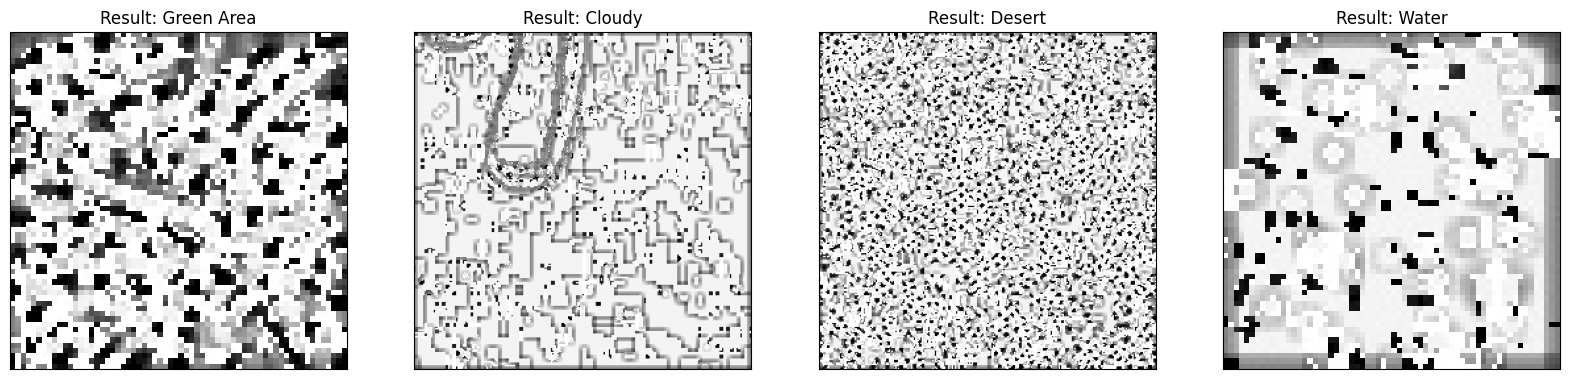

In [33]:
base_path = 'satellite-image/lbpImage'
testImage = {f'{base_path}/cloudy', f'{base_path}/desert', f'{base_path}/green_area', f'{base_path}/water'}

plt.figure(figsize=(20, 15))

for i, path in enumerate(testImage, start=1):
    listImage = os.listdir(path)
    print(listImage)

    if listImage:
        img_path = f'{path}/{listImage[6]}'
        img = cv2.imread(img_path, 0) 
        img_resized = cv2.resize(img, (100, 100))
        img_norm = img_resized / 255.0

        img_final = img_norm.reshape(1, 100, 100, 1)
        
        classes = model.predict(img_final)
        
        index = np.argmax(classes)
        
        class_names = ['Cloudy', 'Desert', 'Green Area', 'Water']
        predict = class_names[index]

        plt.subplot(1, 4, i)
        plt.imshow(img, cmap='gray')
        plt.title(f'Result: {predict}')
        plt.xticks([])
        plt.yticks([])

## Save Model

In [34]:
# model.save('model_satellite.h5')